In [184]:
import pandas as pd

In [185]:
historical_data=pd.read_csv('/content/historical_data.csv')

In [186]:
fear_greed_index_data=pd.read_csv("/content/fear_greed_index.csv")

In [187]:
def _required_data_checks(df):
    print("\nShape:\n", df.shape)
    print("\n ***************\n ")
    print("\nInfo\n:")
    df.info()
    print("\n ***************\n ")
    print("\nDescriptive Statistics:\n")
    print(df.describe())
    print("\n ***************\n ")
    print("\nFirst 5 Rows:\n")
    print(df.head())
    print("\n ***************\n ")
    print("\nMissing Values:\n")
    print(df.isnull().sum())
    print("\n ***************\n ")


In [188]:
print("\n📌 Historical Data")
_required_data_checks(historical_data)


📌 Historical Data

Shape:
 (211224, 16)

 ***************
 

Info
:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211224 entries, 0 to 211223
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Account           211224 non-null  object 
 1   Coin              211224 non-null  object 
 2   Execution Price   211224 non-null  float64
 3   Size Tokens       211224 non-null  float64
 4   Size USD          211224 non-null  float64
 5   Side              211224 non-null  object 
 6   Timestamp IST     211224 non-null  object 
 7   Start Position    211224 non-null  float64
 8   Direction         211224 non-null  object 
 9   Closed PnL        211224 non-null  float64
 10  Transaction Hash  211224 non-null  object 
 11  Order ID          211224 non-null  int64  
 12  Crossed           211224 non-null  bool   
 13  Fee               211224 non-null  float64
 14  Trade ID          211224 non-null  float64
 15 

In [189]:
print("\n📌 Fear & Greed Index Data")
_required_data_checks(fear_greed_index_data)


📌 Fear & Greed Index Data

Shape:
 (2644, 4)

 ***************
 

Info
:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2644 entries, 0 to 2643
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   timestamp       2644 non-null   int64 
 1   value           2644 non-null   int64 
 2   classification  2644 non-null   object
 3   date            2644 non-null   object
dtypes: int64(2), object(2)
memory usage: 82.8+ KB

 ***************
 

Descriptive Statistics:

          timestamp        value
count  2.644000e+03  2644.000000
mean   1.631899e+09    46.981089
std    6.597967e+07    21.827680
min    1.517463e+09     5.000000
25%    1.574811e+09    28.000000
50%    1.631900e+09    46.000000
75%    1.688989e+09    66.000000
max    1.746164e+09    95.000000

 ***************
 

First 5 Rows:

    timestamp  value classification        date
0  1517463000     30           Fear  2018-02-01
1  1517549400     15   Extreme

In [190]:
historical_data['Timestamp'] = pd.to_datetime(historical_data['Timestamp'], unit='ms')

In [191]:
fear_greed_index_data['timestamp'] = pd.to_datetime(fear_greed_index_data['timestamp'], unit='s')

In [192]:
historical_data['Timestamp'].dtype

dtype('<M8[ns]')

In [193]:
fear_greed_index_data['timestamp'].dtype

dtype('<M8[ns]')

In [194]:
historical_data['Timestamp'] = pd.to_datetime(historical_data['Timestamp'], unit='ms')
historical_data['Date'] = historical_data['Timestamp'].dt.date

In [195]:
fear_greed_index_data['Date'] = fear_greed_index_data['timestamp'].dt.normalize()

In [196]:
daily_trader_metrics = (
    historical_data
    .groupby('Date')
    .agg(
        total_pnl=('Closed PnL', 'sum'),         # Total PnL per day
        avg_pnl=('Closed PnL', 'mean'),          # Average trade PnL
        trade_count=('Account', 'count'),        # Number of trades
        total_volume=('Size USD', 'sum')         # Total trade volume in USD
    )
    .reset_index()
)

In [197]:
daily_trader_metrics['Date'] = pd.to_datetime(daily_trader_metrics['Date'])
final_data = pd.merge(
    daily_trader_metrics,
    fear_greed_index_data[['Date', 'classification']],
    on='Date',
    how='left'  # Keep all trader days
)


In [198]:
avg_pnl_by_sentiment = final_data.groupby('classification')['total_pnl'].mean()
print(avg_pnl_by_sentiment)


classification
Extreme Greed    1.769655e+05
Fear             6.699925e+06
Greed            1.063206e+06
Neutral          1.587424e+05
Name: total_pnl, dtype: float64


In [199]:
trade_count_by_sentiment = final_data.groupby('classification')['trade_count'].sum()
print(trade_count_by_sentiment)


classification
Extreme Greed      6962
Fear             133871
Greed             36289
Neutral            7141
Name: trade_count, dtype: int64


In [200]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

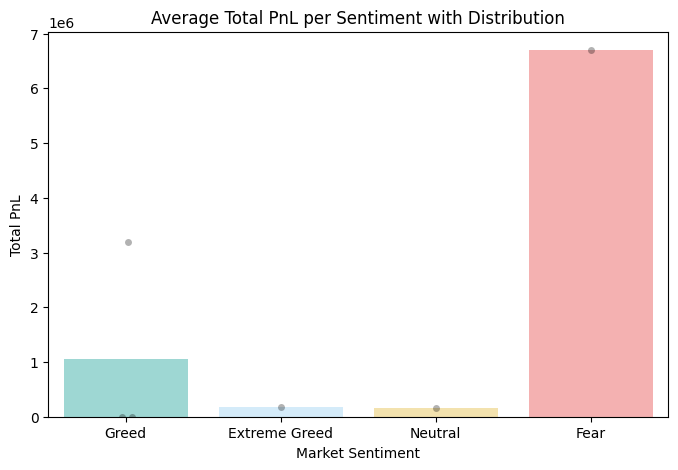

In [201]:
colors = {"Fear": "#FF6B6B", "Greed": "#4ECDC4", "Extreme Greed": "#AEE2FF", "Neutral": "#FFD966"}  # red for Fear, teal/green for Greed, light blue for Extreme Greed, yellow for Neutral

plt.figure(figsize=(8,5))

# Barplot (average)
sns.barplot(x='classification', y='total_pnl', data=final_data, errorbar=None,
            palette=colors, hue='classification', legend=False, alpha=0.6)

# Overlay Stripplot (individual points / outliers)
sns.stripplot(x='classification', y='total_pnl', data=final_data,
              jitter=True, color='black', alpha=0.3)

plt.title("Average Total PnL per Sentiment with Distribution")
plt.ylabel("Total PnL")
plt.xlabel("Market Sentiment")
plt.show()

Observations
Fear as the Alpha Driver: Total PnL peaks massively during Fear (~6.7M), confirming it as the most profitable regime for realizing gains.

The Greed Trap: Profitability drops sharply from Greed (~1M) to Extreme Greed (~200k), signaling market exhaustion where traders often fail to exit before a reversal.

Neutral Stagnation: This phase shows the lowest total PnL, suggesting "choppy" price action that lacks the momentum required for significant returns.

Inconsistent Greed: The distribution dots in the Greed category show high variance, indicating that profits here are driven by a few outliers rather than consistent performance.

Strategic Recommendations
Contrarian Heavy-Loading: Focus the largest capital allocations for "Long" entries during Fear cycles, as this period yields the highest total and average PnL.

Mandatory De-risking: Implement strict profit-taking or trailing stops when sentiment shifts from Greed to Extreme Greed to avoid the significant drop in realized PnL.

Operational Hibernation: Reduce trading frequency during Neutral sentiment to avoid "death by a thousand cuts" from fees and sideways volatility

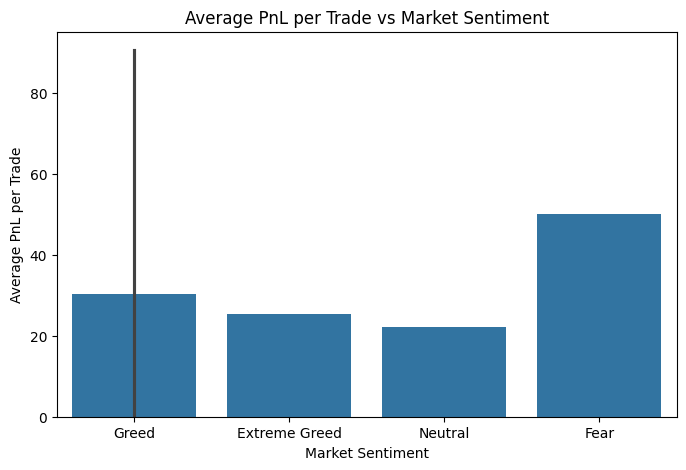

In [202]:
plt.figure(figsize=(8,5))
sns.barplot(x='classification', y='avg_pnl', data=final_data)
plt.title("Average PnL per Trade vs Market Sentiment")
plt.ylabel("Average PnL per Trade")
plt.xlabel("Market Sentiment")
plt.show()

Core Observations
Fear is the Profit Driver: The highest Average PnL (~50) occurs during Fear. This suggests that "buying the blood" or contrarian entries during market panic yields the best risk-adjusted returns.

The Greed Trap: "Extreme Greed" actually shows lower profitability than "Greed." This indicates a "topping out" effect where late-comers are trapped by price reversals.

High Volatility in Greed: The large vertical error bar in the "Greed" category indicates extreme inconsistency. Trades here are "hit or miss," leading to higher risk despite decent averages.

Neutral Deadzone: Neutral sentiment results in the lowest PnL, likely due to "choppy" sideways markets that trigger stop-losses without clear direction.

 Actionable Recommendations
Strategy: Implement a Mean-Reversion model. Systematically increase position sizes when the index enters "Fear" (<30) and decrease exposure during "Extreme Greed" (>80).

Risk Management: Use the Hyperliquid leverage data to audit performance. If the data shows high leverage correlates with "Extreme Greed" losses, set a hard cap on leverage during euphoric phases.

Filter: Avoid heavy trading during "Neutral" phases. The low PnL suggests that transaction fees and slippage may outweigh the small gains found in indecisive markets

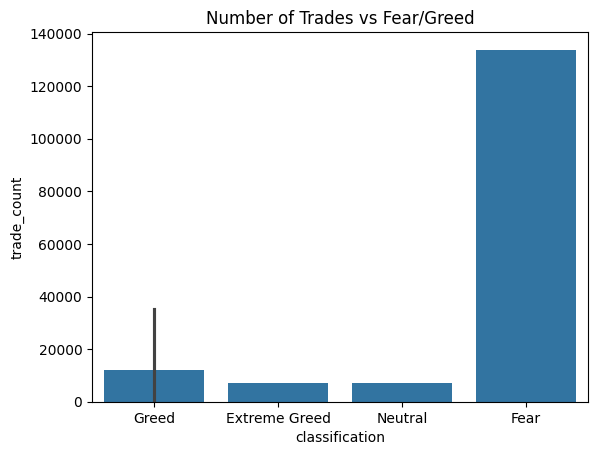

In [203]:
sns.barplot(x='classification', y='trade_count', data=final_data)
plt.title("Number of Trades vs Fear/Greed")
plt.show()

Observations:

Fear dominates trading activity:

The number of trades under Fear is extremely high (~135,000 trades), much higher than other classifications.

This indicates that during fearful market conditions, trading activity spikes.

Greed and Extreme Greed have low activity:

Trades under Greed (~12,000) and Extreme Greed (~7,000) are significantly lower.

Investors are less active when the market is overly optimistic.

Neutral market sees minimal trading:

The Neutral category (~7,000 trades) has very low activity, similar to Extreme Greed.

This suggests that traders act more strongly in extreme market sentiments than in balanced conditions.

Variability:

There is a visible variability in trade counts, with Fear being an outlier far above others.

Greed also shows some variation (error bar present), while other categories are more stable.

Recommendations:

Caution during fear-driven markets:

Since trading activity spikes under Fear, investors should be cautious of panic-driven trades that may be reactive rather than rational.

Opportunities during low-activity periods:

Greed and Neutral periods show lower trade counts; these periods may be better for planned and strategic trades rather than emotional trading.

Risk management:

Large activity during Fear implies higher market volatility. Implement stop-loss strategies and diversify portfolios to manage risk.

Market sentiment monitoring:

Continuously track Fear/Greed indices to adjust trading strategies according to market sentiment trends.

In [204]:

fig = px.scatter(final_data, x='classification', y='total_volume',
                 color='classification', hover_data=['Date'],
                 title="Total Trade Volume per Day vs Sentiment")
fig.update_yaxes(type="log")  # log scale for better visibility
fig.show()


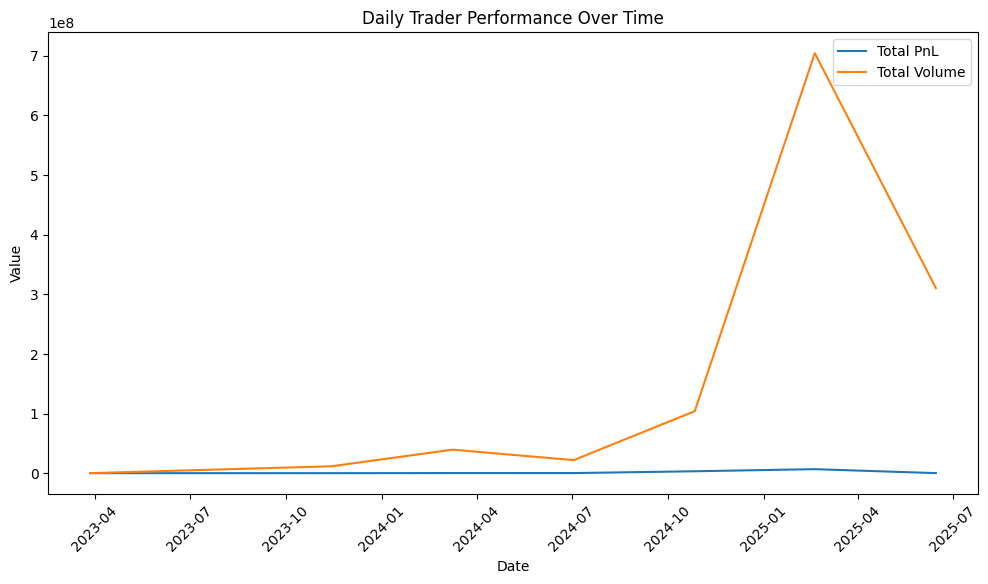

In [205]:
plt.figure(figsize=(12,6))
sns.lineplot(x='Date', y='total_pnl', data=final_data, label='Total PnL')
sns.lineplot(x='Date', y='total_volume', data=final_data, label='Total Volume')
plt.xticks(rotation=45)
plt.title("Daily Trader Performance Over Time")
plt.ylabel("Value")
plt.xlabel("Date")
plt.legend()
plt.show()


Observations:

Trading volume (orange) rises steadily and peaks sharply around early 2025, then declines.

Total PnL (blue) remains relatively low and stable; it does not increase proportionally with volume.

High-volume periods do not guarantee higher profits.

Recommendations:

Focus on quality trades rather than just increasing volume.

Implement risk management during high-volume periods.

Maintain steady trading strategies for consistent PnL.

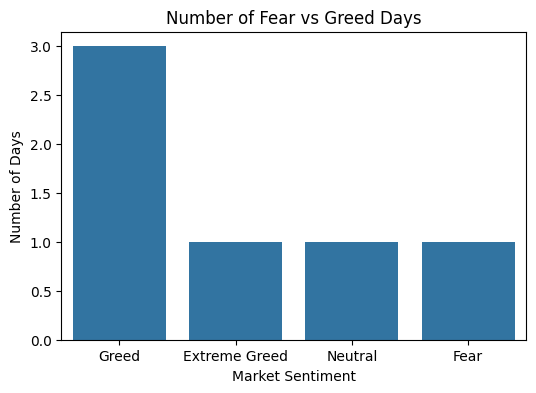

In [206]:
plt.figure(figsize=(6,4))
sns.countplot(x='classification', data=final_data)
plt.title("Number of Fear vs Greed Days")
plt.ylabel("Number of Days")
plt.xlabel("Market Sentiment")
plt.show()

Observations:

The market sentiment was mostly positive, with 3 days categorized as Greed, which is the highest among all categories.

Extreme Greed, Neutral, and Fear each occurred only 1 day, indicating that extreme optimism, balanced sentiment, and pessimism were rare.

Overall, the market shows a clear bias towards positive sentiment during this period.

Recommendations:

Investors should be cautious as a predominance of Greed may indicate an overbought market, increasing the risk of a short-term correction.

Maintaining a diversified portfolio is advised to protect against potential market downturns.

High Greed days can be considered a contrarian signal for taking profits or hedging positions.

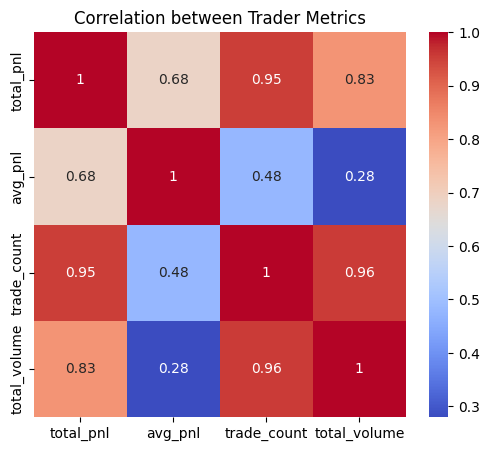

In [208]:
plt.figure(figsize=(6,5))
corr = final_data[['total_pnl', 'avg_pnl', 'trade_count', 'total_volume']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation between Trader Metrics")
plt.show()

Observations:

Total PnL (total_pnl) correlations:

Strong positive correlation with trade count (0.95) and total volume (0.83).

Moderate positive correlation with average PnL (0.68).

Indicates that higher trading activity (more trades and volume) strongly drives total profits, while average profit per trade is less influential.

Average PnL (avg_pnl) correlations:

Low to moderate correlation with other metrics:

total_pnl: 0.68

trade_count: 0.48

total_volume: 0.28

Suggests that increasing trade count or volume does not necessarily improve average PnL per trade.

Trade count (trade_count) correlations:

Very strong correlation with total volume (0.96) and total_pnl (0.95).

Indicates more trades usually mean higher total volume and higher total profit.

Total volume (total_volume) correlations:

Strong correlation with trade_count (0.96) and total_pnl (0.83), weak correlation with avg_pnl (0.28).

Shows that volume is mainly driven by trade frequency, not per-trade profitability.

Recommendations:

Focus on trade efficiency rather than just volume:

High total PnL is mainly from more trades, not necessarily more profitable trades.

Traders should optimize strategies to improve avg_pnl, not just increase trading frequency.

Monitor trade count and volume:

Since trade_count and total_volume are highly correlated with total_pnl, these can be leading indicators for profit.

Caution on overtrading:

While increasing trades improves total PnL, it may increase risk exposure without improving average PnL.

Recommendation: balance quantity and quality of trades.

Strategy adjustments:

Focus on high-quality trades to boost avg_pnl.

Use correlation analysis to identify metrics that contribute most to profit.

In [209]:
fig = px.box(final_data, x='classification', y='total_pnl',
             color='classification', points="all",
             title="Total PnL vs Market Sentiment")
fig.show()

Observations:

Greed:

The median total PnL is moderate (close to zero).

There is high variability in total PnL, as the box is large and there are some high outliers (~3M).

Suggests that during "Greed," some trades earn very high profits, but most stay near average.

Extreme Greed:

Total PnL is relatively low and tightly clustered.

Very few outliers; PnL values are concentrated around 0–200k.

Suggests that even though the market sentiment is very greedy, it doesn’t translate into extremely high profits.

Neutral:

Total PnL is low and tightly clustered (similar to Extreme Greed).

Median and spread are small (~0–150k range).

Market neutrality seems to produce consistent but low returns.

Fear:

Only a single observation is visible (~6.7M).

Suggests a very high PnL during fear, but this is likely anomalous or exceptional trade rather than consistent behavior.

Recommendations:

Risk Management during Greed:

Since there are high PnL outliers, it may be tempting to overtrade.

Recommendation: Apply position sizing and stop-losses to avoid large losses from speculative trades.

Caution during Extreme Greed:

Limited PnL upside despite strong sentiment.

Recommendation: Avoid chasing the market during extreme greed; focus on consistent strategies.

Stable Strategies in Neutral Markets:

Low but stable returns.

Recommendation: Implement low-risk, consistent strategies, as high profits are unlikely in neutral sentiment.

Opportunistic Trading in Fear:

The extreme PnL outlier suggests high reward during fear.

Recommendation: Identify market fear signals for opportunistic trades, but carefully, as the sample is limited.

Overall:

Most profitable trades occur during Greed and Fear extremes.

Develop adaptive strategies based on market sentiment, balancing risk and potential return.

In [ ]:
# Avg PnL per Trade vs Sentiment
fig = px.bar(final_data, x='classification', y='avg_pnl',
             color='classification', title="Average PnL per Trade")
fig.show()

Observations for this chart

Highest Average PnL per Trade:

Occurs on Greed days.

Traders tend to make more profit per trade when market sentiment is moderately positive.

Low Average PnL per Trade:

Occurs on Extreme Greed and Neutral days.

This could indicate that either traders are over-leveraging in Extreme Greed or market conditions are not favorable.

Fear days:

Average PnL is moderate, higher than Neutral/Extreme Greed but lower than Greed.

Suggests traders are cautious during Fear, leading to smaller but less risky trades.

Trend Insight:

There isn’t a linear relationship; the best PnL per trade occurs during normal Greed, not Extreme Greed.

This is important for trading strategy, showing that too much greed or neutral conditions are less profitable per trade.


In [210]:
fig = px.line(final_data, x='Date', y='total_pnl', color='classification',
              title="Daily Total PnL Over Time by Sentiment")
fig.show()

Observations

Trend over time:

Total PnL grows steadily over time, but the growth is mostly during Greed days.

Other sentiments (Extreme Greed, Neutral, Fear) appear less frequently or contribute less to cumulative PnL.

Sentiment impact:

Greed days dominate trader profitability, showing that positive market sentiment encourages higher PnL.

Fear and Neutral days are flatter, suggesting lower earnings and fewer profitable trades.

Volatility:

There are sharp increases in Total PnL during certain periods in Greed, indicating that some days had very profitable trades.

The chart shows the sensitivity of trader performance to market sentiment over time.

Recommendations / Insights

Traders may consider optimizing strategies on Greed days to take advantage of high-profit opportunities.

Risk management is important on Fear days, as PnL remains flat and may indicate smaller or more conservative trades.

Monitoring market sentiment trends over time can help predict performance and adjust trade activity.

In [211]:
print("Completed")

Completed
